**A1: Boxplot**

/tmp/ipython-input-814944559.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subclass_labels_only, rotation=90, ha='center', fontsize=10)


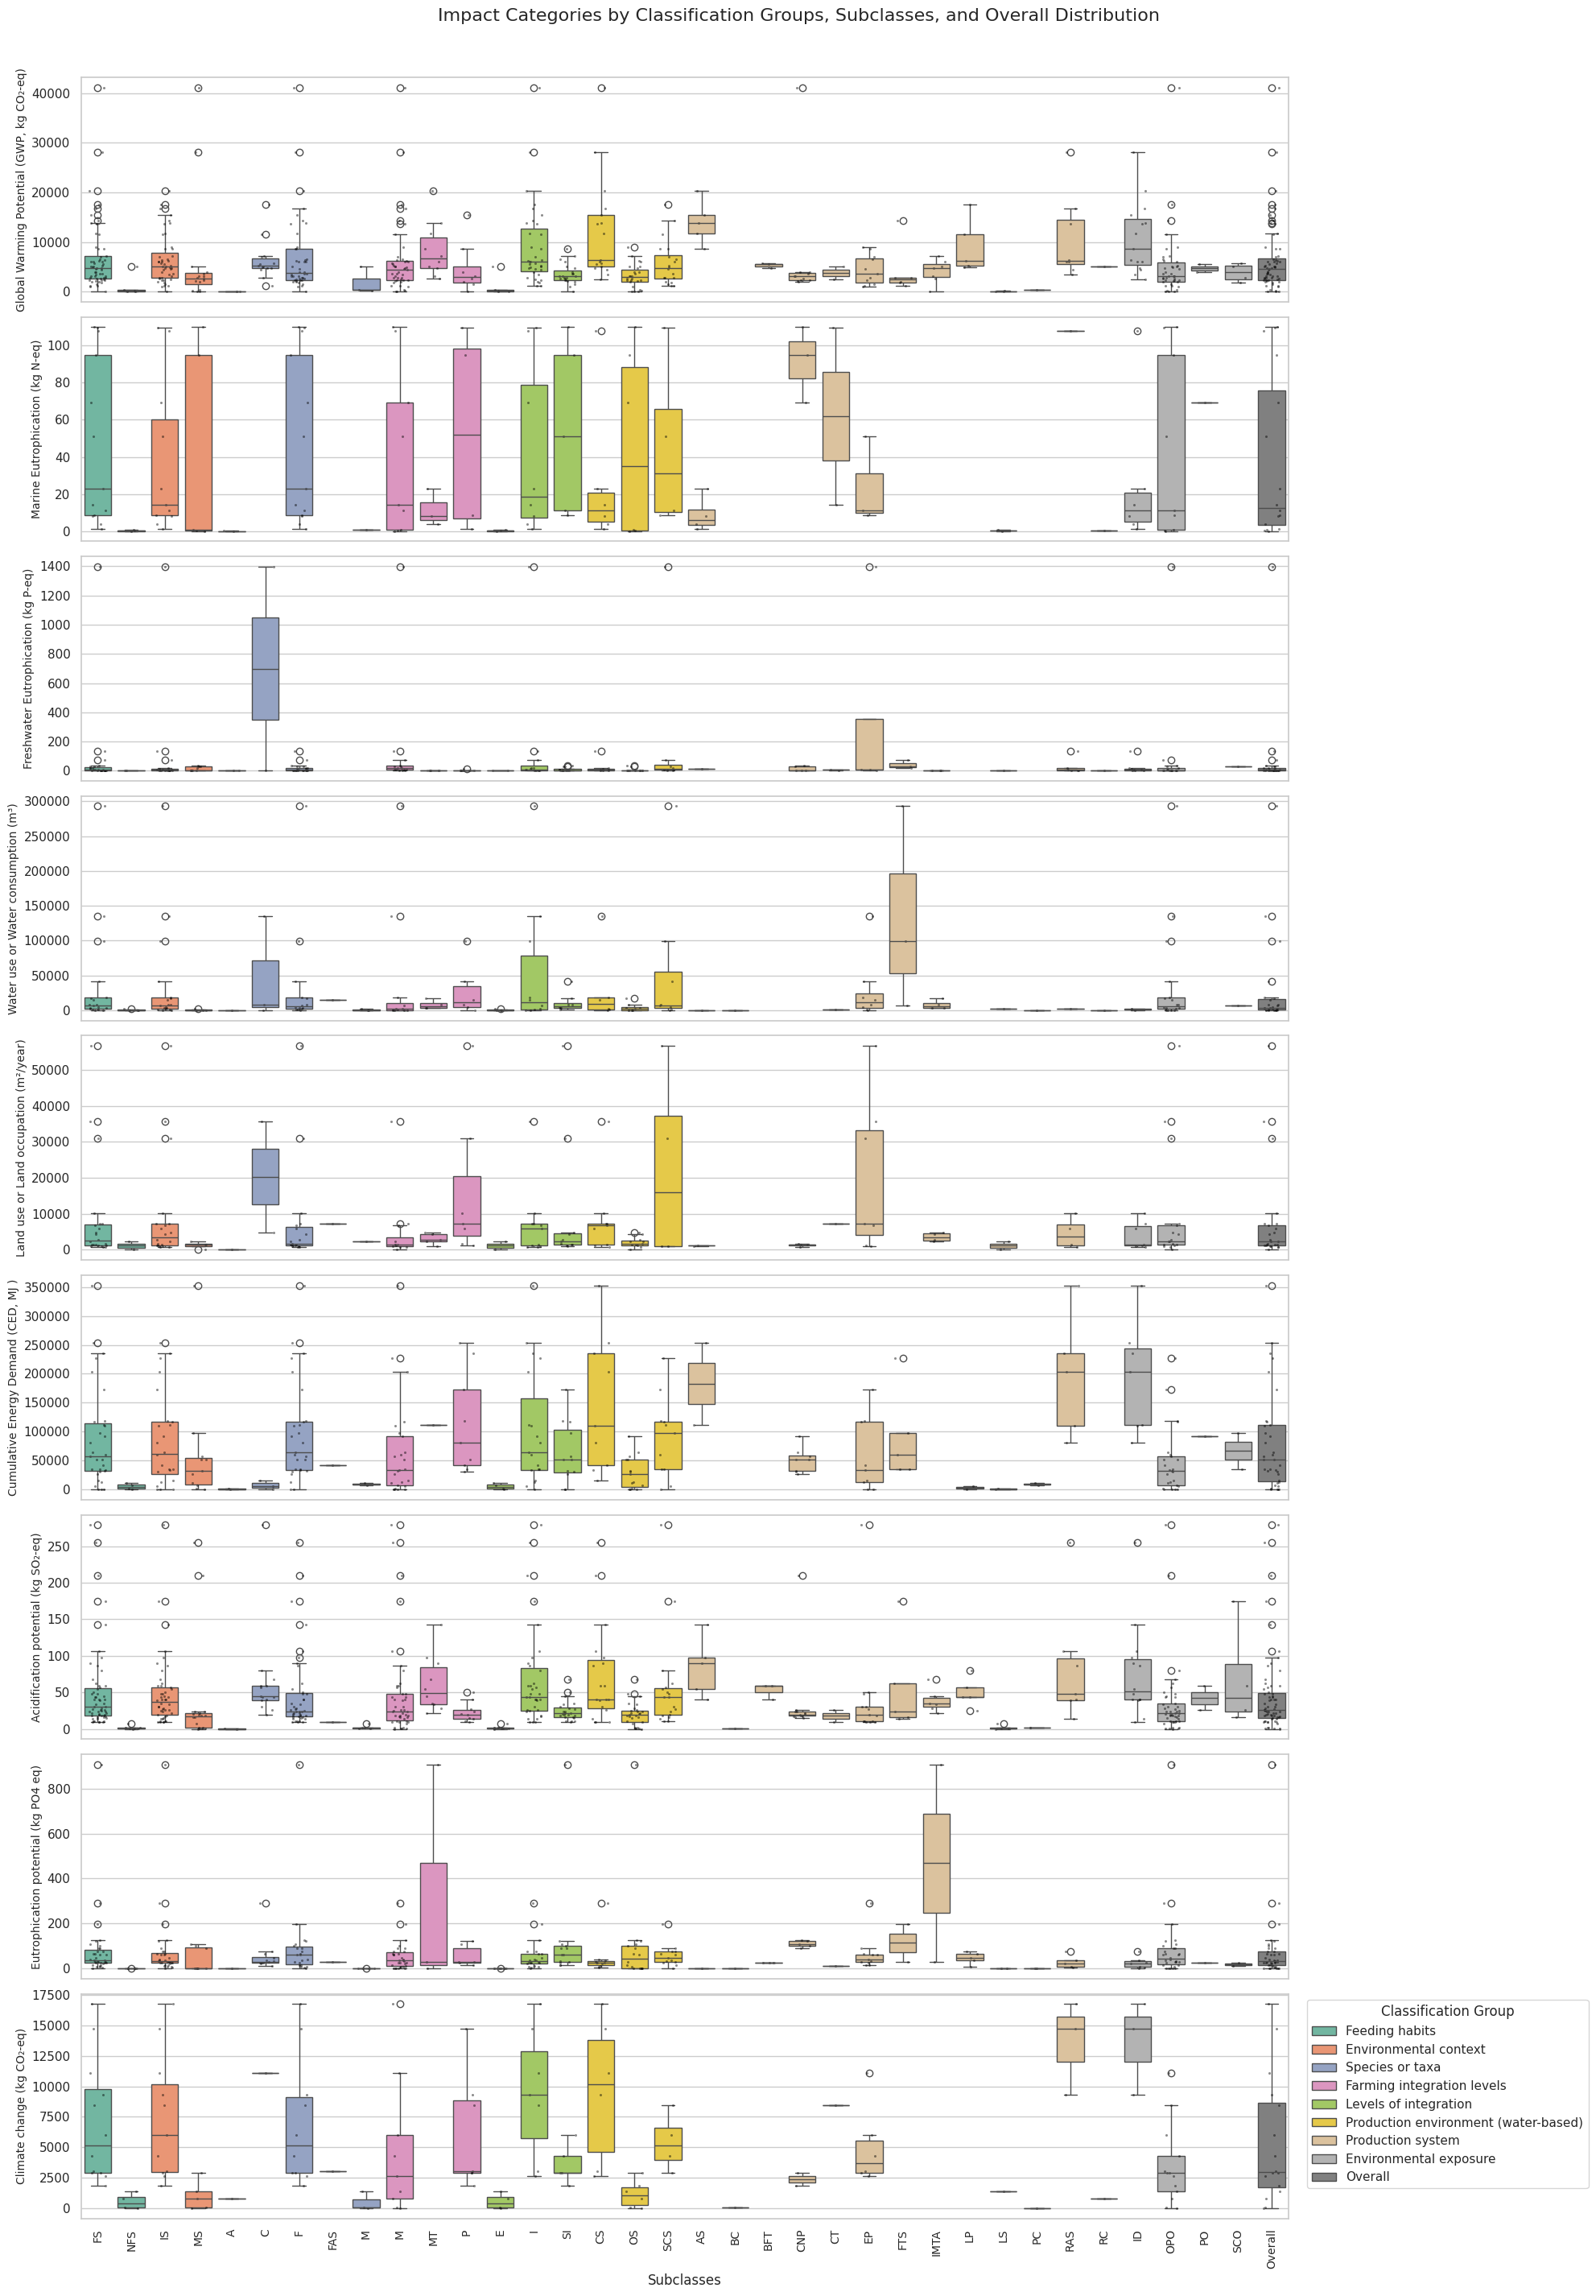

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel('/content/A1 Contributon analys (11).xlsx')

# Define classification groups (X-axis groupings)
x_classes = [
    "Feeding habits",
    "Environmental context",
    "Species or taxa",
    "Farming integration levels",
    "Levels of integration",
    "Production environment (water-based)",
    "Production system",
    "Environmental exposure"
]

# Define impact categories (Y-axis)
impact_categories = [
    "Global Warming Potential (GWP, kg CO₂-eq)",
    "Marine Eutrophication (kg N-eq)",
    "Freshwater Eutrophication (kg P-eq)",
    "Water use or Water consumption (m³)",
    "Land use or Land occupation (m²/year)",
    "Cumulative Energy Demand (CED, MJ )",
    "Acidification potential (kg SO₂-eq)",
    "Eutrophication potential (kg PO4 eq)",
    "Climate change (kg CO₂-eq)"
]

# Set style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2", n_colors=len(x_classes))
group_color_dict = dict(zip(x_classes, palette))

# Step 1: Get all (Group, Subclass) combinations
order_tuples = []
for group in x_classes:
    if group in df.columns:
        subclasses = df[group].dropna().unique().tolist()
        for subclass in sorted(subclasses):
            order_tuples.append((group, subclass))

# Step 2: Create ordered x labels
ordered_categories = [f"{grp} | {sub}" for grp, sub in order_tuples]
subclass_labels_only = [sub for grp, sub in order_tuples]  # for x-tick labels

# Add "Overall" as the last label
ordered_categories.append("Overall")
subclass_labels_only.append("Overall")

# Step 3: Create subplots
fig, axes = plt.subplots(nrows=len(impact_categories), ncols=1, figsize=(20, 30), sharex=True)

# Create a list to collect all melted data for Excel
all_melted_data = []

# ✅ Consistent point styling for "underlying data"
POINT_SIZE = 2.2
POINT_ALPHA = 0.45
POINT_JITTER = 0.25

# Step 4: Plot each impact category
for i, (ax, impact) in enumerate(zip(axes, impact_categories)):
    df_melted = pd.DataFrame()

    # Melt for each classification
    for group in x_classes:
        if group in df.columns and impact in df.columns:
            subset = df[[group, impact]].dropna()
            subset.columns = ['Category', 'Impact']
            subset['Group'] = group
            subset['CatLabel'] = group + ' | ' + subset['Category'].astype(str)
            df_melted = pd.concat([df_melted, subset])

    # Add the 'Overall' category (without classification)
    overall_values = df[impact].dropna().values
    overall_df = pd.DataFrame({
        'Category': ['Overall'] * len(overall_values),
        'Impact': overall_values,
        'Group': ['Overall'] * len(overall_values),
        'CatLabel': ['Overall'] * len(overall_values)
    })
    df_melted = pd.concat([df_melted, overall_df], ignore_index=True)

    # Append impact category info
    df_melted['Impact Category'] = impact
    all_melted_data.append(df_melted)

    # Plot boxplot
    sns.boxplot(
        x='CatLabel',
        y='Impact',
        hue='Group',
        data=df_melted,
        ax=ax,
        palette={**group_color_dict, "Overall": "gray"},
        dodge=False,
        order=ordered_categories
    )

    # Overlay underlying observations (raw data points)
    # Uses gray points to avoid conflicting with group colors (keeps box colors readable).
    sns.stripplot(
        x='CatLabel',
        y='Impact',
        data=df_melted,
        ax=ax,
        order=ordered_categories,
        jitter=POINT_JITTER,
        size=POINT_SIZE,
        alpha=POINT_ALPHA,
        color='black',
        dodge=False,
        zorder=2
    )

    ax.set_ylabel(impact, fontsize=10)
    ax.set_xlabel("")

    if i != len(axes) - 1:
        ax.set_xticklabels([])
        ax.get_legend().remove()
    else:
        ax.set_xticklabels(subclass_labels_only, rotation=90, ha='center', fontsize=10)
        ax.set_xlabel("Subclasses", fontsize=12)
        ax.legend(title="Classification Group", bbox_to_anchor=(1.01, 1), loc='upper left')

# Final layout
plt.suptitle("Impact Categories by Classification Groups, Subclasses, and Overall Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Save the collected data to Excel
result_df = pd.concat(all_melted_data, ignore_index=True)
result_df.to_excel("Plotted_Impact_Values.xlsx", index=False)

**A1: Statistics**

In [ ]:
##Code for statistics

!pip install scikit-posthocs

import pandas as pd
import numpy as np
from scipy.stats import normaltest, levene, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import scikit_posthocs as sp
import warnings

warnings.filterwarnings('ignore')

# Load your dataset - update the filename here!
df = pd.read_excel('/content/A1 Statistics.xlsx)

# List all diversity classification columns to test
diversity_cols = [
    'Feeding habits',
    'Environmental context',
    'Species or taxa',
    'Farming integration levels',
    'Levels of integration',
    'Production environment (water-based)',
    'Production system',
    'Environmental exposure'
]

# List of impact categories (dependent variables)
impact_cols = [
    "Global Warming Potential (GWP, kg CO₂-eq)",
    "Marine Eutrophication (kg N-eq)",
    "Freshwater Eutrophication (kg P-eq)",
    "Water use or Water consumption (m³)",
    "Land use or Land occupation (m²/year)",
    "Cumulative Energy Demand (CED, MJ )",
    "Acidification potential (kg SO₂-eq)",
    "Eutrophication potential (kg PO4 eq)",
    "Climate change (kg CO₂-eq)",
]

# Prepare Excel writer for results output for ANOVA/KW per sheet
excel_writer = pd.ExcelWriter('analysis_results_multi_diversity.xlsx', engine='openpyxl')

# To store summary of all tests for summary sheet
summary_records = []

# Prepare a list to gather the detailed summary entries for post hoc and interpretations
detailed_summary = []

def pval_to_significance(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'  # not significant

for impact in impact_cols:
    for group_col in diversity_cols:
        # Extract relevant columns, drop rows missing group or impact
        temp = df[[group_col, impact]].dropna()

        # Skip if less than 2 groups
        if temp[group_col].nunique() < 2:
            continue

        # Group data values for statistical testing
        group_values = [grp[impact].values for name, grp in temp.groupby(group_col)]

        # Skip if any group has too few samples to test normality reliably (optional)
        if any(len(g) < 3 for g in group_values):
            # Still can run Kruskal-Wallis but normality test unreliable; proceed anyway
            pass

        # Normality test per group (only if n >=8 for normaltest validity)
        normal_pvals = []
        for g in group_values:
            if len(g) >= 8:
                pval = normaltest(g)[1]
            else:
                pval = np.nan  # Not enough data for reliable normality test
            normal_pvals.append(pval)

        normality = all((p > 0.05) if not np.isnan(p) else True for p in normal_pvals)  # Treat nans as pass

        # Homogeneity of variances test (Levene)
        if all(len(g) > 1 for g in group_values):
            levene_stat, levene_p = levene(*group_values)
            homogeneity = levene_p > 0.05
        else:
            levene_p = np.nan
            homogeneity = False

        # Select test & run
        if normality and homogeneity:
            # Parametric test ANOVA
            model = ols(f'Q("{impact}") ~ C(Q("{group_col}"))', data=temp).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            main_p = anova_table['PR(>F)'][0]
            test_used = 'ANOVA'
            posthoc_df = None
            if main_p < 0.05:
                tukey_res = pairwise_tukeyhsd(temp[impact], temp[group_col])
                posthoc_df = pd.DataFrame(tukey_res.summary().data[1:], columns=tukey_res.summary().data[0])
        else:
            # Non-parametric: Kruskal-Wallis
            kw_stat, main_p = kruskal(*group_values)
            anova_table = pd.DataFrame({'statistic': [kw_stat], 'p-value': [main_p]})
            test_used = 'Kruskal-Wallis'
            posthoc_df = None
            if main_p < 0.05:
                posthoc_df = sp.posthoc_dunn(temp, val_col=impact, group_col=group_col, p_adjust='bonferroni')

        # Save results to sheet (ANOVA/KW + posthoc)
        sheet_name = f"{impact[:20]}_{group_col[:20]}"  # max 31 char for Excel sheets
        startrow = 0
        # Summary info df for this test
        summary_info = {
            'Impact Category': impact,
            'Diversity Classification': group_col,
            'Test Used': test_used,
            'Main p-value': main_p,
            'All Groups Passed Normality': normality,
            'Levene Test p-value': levene_p,
            'Homogeneous Variances': homogeneity,
            'Group Normality p-values': normal_pvals
        }
        summary_df = pd.DataFrame.from_dict(summary_info, orient='index', columns=['Value'])
        summary_df.to_excel(excel_writer, sheet_name=sheet_name, startrow=startrow)
        startrow += len(summary_df) + 3
        anova_table.to_excel(excel_writer, sheet_name=sheet_name, startrow=startrow)
        startrow += len(anova_table) + 3
        if posthoc_df is not None:
            posthoc_df.to_excel(excel_writer, sheet_name=sheet_name, startrow=startrow)

        # Add to summary records for overall summary sheet
        summary_records.append({
            'Impact Category': impact,
            'Diversity Classification': group_col,
            'Test Used': test_used,
            'Main p-value': main_p,
            'Significant?': 'YES' if main_p < 0.05 else 'NO'
        })

        # Prepare detailed summary entries (post hoc interpretation etc)
        normality_result = 'Pass' if normality else 'Fail'
        homogeneity_result = 'Pass' if homogeneity else 'Fail'
        significance = 'Yes' if main_p < 0.05 else 'No'
        posthoc_name = 'Tukey HSD' if (significance == 'Yes' and test_used == 'ANOVA') else ('Dunn' if (significance == 'Yes' and test_used == 'Kruskal-Wallis') else '')

        posthoc_text = ''
        interpretation = ''

        if significance == 'Yes' and posthoc_df is not None:
            if test_used == 'ANOVA':
                significant_pairs = posthoc_df[posthoc_df['reject'] == True]
                if not significant_pairs.empty:
                    pairs = []
                    for _, row in significant_pairs.iterrows():
                        pairs.append(f"{row['group1']} vs {row['group2']} (p={row['p-adj']:.4g})")
                    posthoc_text = '; '.join(pairs)
                    interpretation = f"Significant differences found between subclass groups."
                else:
                    posthoc_text = 'No significant pairwise differences.'
                    interpretation = 'Overall test significant, but no pairwise difference in post hoc.'
            else:
                # Dunn test returns a matrix of p-values
                sig_pairs = []
                for i, row_name in enumerate(posthoc_df.index):
                    for j, col_name in enumerate(posthoc_df.columns):
                        if i < j:
                            p_val = posthoc_df.iloc[i, j]
                            if p_val < 0.05:
                                sig_pairs.append(f"{row_name} vs {col_name} (p={p_val:.4g})")
                if sig_pairs:
                    posthoc_text = '; '.join(sig_pairs)
                    interpretation = "Significant differences found between subclass groups."
                else:
                    posthoc_text = 'No significant pairwise differences.'
                    interpretation = 'Overall test significant, but no pairwise difference in post hoc.'
        else:
            posthoc_text = ''
            interpretation = 'No significant difference between groups.'

        detailed_summary.append({
            'Impact Category': impact,
            'Diversity Classification': group_col,
            'Normality': normality_result,
            'Homogeneity': homogeneity_result,
            'Test Used': test_used,
            'Significant': significance,
            'Post-hoc Test': posthoc_name,
            'Post-hoc Results': posthoc_text,
            'Interpretation': interpretation
        })

# Save the summary sheet with all test summaries
summary_df_all = pd.DataFrame(summary_records)
summary_df_all.to_excel(excel_writer, sheet_name='Summary', index=False)

# Close excel writer to save the multi-sheet file
excel_writer.close()

# Now save detailed summary (posthoc interpretations) to a separate Excel file
detailed_df = pd.DataFrame(detailed_summary)
detailed_df.to_excel("detailed_statistical_summary.xlsx", index=False)

print("All analyses complete.")
print("See 'analysis_results_multi_diversity.xlsx' for detailed test results per impact × diversity group.")
print("See 'detailed_statistical_summary.xlsx' for the detailed summary and post-hoc interpretations.")

ModuleNotFoundError: No module named 'scikit_posthocs'

**A1: Bubble plot**

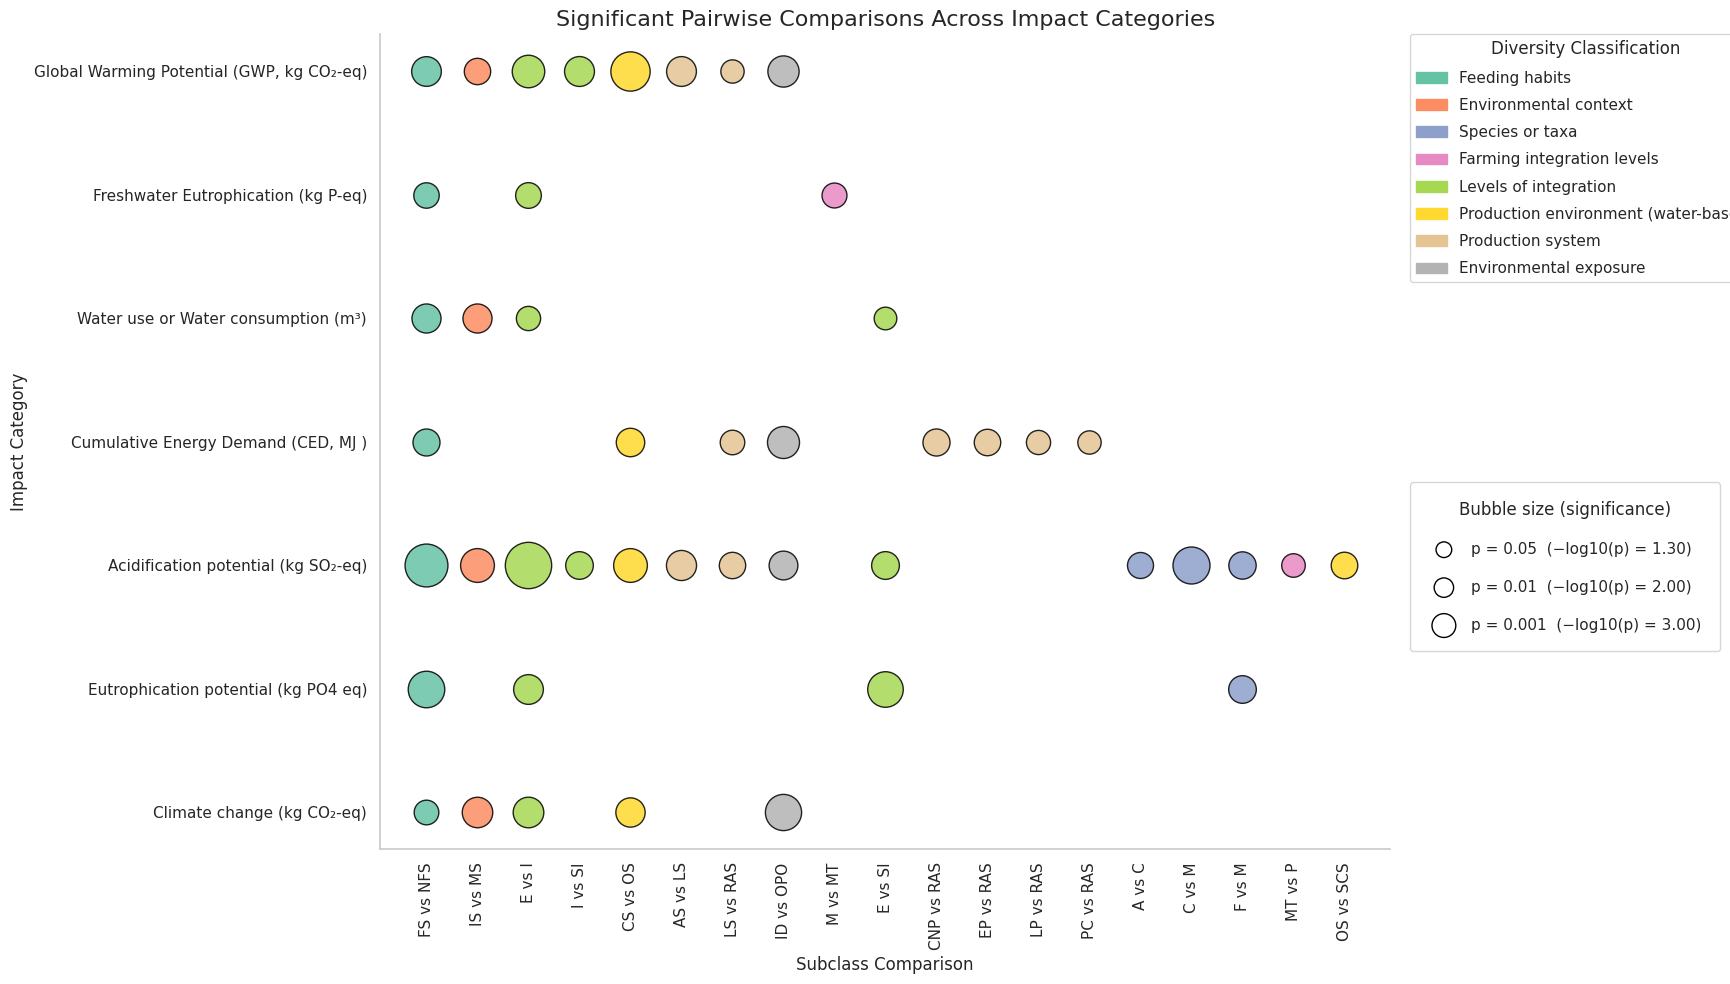

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Load the Excel file
df = pd.read_excel('/content/A1 bubble plot (2).xlsx')

# Define the classification groups and assign custom palette
x_classes = [
    "Feeding habits",
    "Environmental context",
    "Species or taxa",
    "Farming integration levels",
    "Levels of integration",
    "Production environment (water-based)",
    "Production system",
    "Environmental exposure"
]
palette = sns.color_palette("Set2", n_colors=len(x_classes))
group_color_dict = dict(zip(x_classes, palette))

# Expand subclass comparisons into rows
data_expanded = []
for _, row in df.iterrows():
    impact = row['Impact Category']
    classification = row['Diversity Classification']
    results = row['Post-hoc Results']

    if isinstance(results, str) and "No significant" not in results:
        comparisons = results.split(';')
        for comp in comparisons:
            match = re.search(r"(.*?)\s*\(p\s*=\s*([0-9.eE+-]+)\)", comp.strip())
            if match:
                subclass = match.group(1).strip()
                p_val = float(match.group(2))
                data_expanded.append({
                    'Impact Category': impact,
                    'Diversity Classification': classification,
                    'Subclass Comparison': subclass,
                    'p-value': p_val,
                    'bubble_size': -np.log10(p_val)
                })

# Convert to DataFrame
df_plot = pd.DataFrame(data_expanded)

# Set up the figure
fig, ax = plt.subplots(figsize=(22, 10))

# Assign colors
df_plot['Color'] = df_plot['Diversity Classification'].map(group_color_dict).fillna('gray')

# Plot bubbles
for _, row in df_plot.iterrows():
    ax.scatter(
        x=row['Subclass Comparison'],
        y=row['Impact Category'],
        s=row['bubble_size'] * 200,
        color=row['Color'],
        edgecolors='black',
        alpha=0.85
    )

# Labels and styling
plt.xticks(rotation=90)
plt.xlabel("Subclass Comparison", fontsize=12)
plt.ylabel("Impact Category", fontsize=12)
plt.title("Significant Pairwise Comparisons Across Impact Categories", fontsize=16)

ax.invert_yaxis()

# ----------------------------
# Color legend
# ----------------------------
legend_handles = [Patch(color=color, label=label) for label, color in group_color_dict.items()]
color_legend = ax.legend(
    handles=legend_handles,
    title='Diversity Classification',
    bbox_to_anchor=(1.02, 1.00),
    loc='upper left',
    borderaxespad=0,
    labelspacing=0.8
)

# ----------------------------
# Bubble size legend (FIXED SPACING)
# ----------------------------
p_levels = [0.05, 0.01, 0.001]

size_handles = [
    ax.scatter([], [], s=(-np.log10(p) * 200),
               facecolors='none', edgecolors='black')
    for p in p_levels
]

size_labels = [
    f"p = {p:g}  (−log10(p) = {(-np.log10(p)):.2f})"
    for p in p_levels
]

size_legend = ax.legend(
    handles=size_handles,
    labels=size_labels,
    title="Bubble size (significance)",
    bbox_to_anchor=(1.02, 0.45),
    loc='upper left',
    borderaxespad=0,
    frameon=True,
    labelspacing=1.5,      # Increased vertical spacing
    borderpad=1.2,         # Padding inside legend box
    markerscale=0.7        # Slightly reduce legend marker size
)

# Keep both legends
ax.add_artist(color_legend)

# Layout
plt.tight_layout(rect=[0, 0, 0.80, 1])
sns.despine()
plt.grid(False)
plt.show()

**A2: Correlation map**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load file
df = pd.read_excel('/content/A2 Correlation map.xlsx')

# Subsystem order from Excel
yes_no_cols = df.columns[:7].tolist()

# Clean Yes/No values
df[yes_no_cols] = df[yes_no_cols].applymap(lambda x: 'Yes' if str(x).strip().lower() == 'yes' else 'No')

# Diversity classification columns
diversity_cols = df.columns[7:]

# Long format reshaping
melted = df.melt(id_vars=yes_no_cols, value_vars=diversity_cols,
                 var_name='Category', value_name='Subclass')
melted.dropna(subset=['Subclass'], inplace=True)

# Create combined labels
melted['Subclass_Label'] = melted['Category'].str.strip() + ": " + melted['Subclass'].astype(str).str.strip()

# Subsystem inclusion melt
melted_yes = melted.melt(id_vars=['Subclass_Label'], value_vars=yes_no_cols,
                         var_name='Subsystem', value_name='Included')
melted_yes = melted_yes[melted_yes['Included'] == 'Yes']

# Total studies per subclass
total_studies = melted['Subclass_Label'].value_counts().to_dict()

# Create frequency matrix
count_matrix = pd.crosstab(melted_yes['Subsystem'], melted_yes['Subclass_Label'])

# Convert to percentages
percentage_matrix = count_matrix.copy()
for col in percentage_matrix.columns:
    percentage_matrix[col] = (percentage_matrix[col] / total_studies[col]) * 100

# Reorder columns and rows as per Excel
ordered_labels = []
for col in diversity_cols:
    unique_vals = df[col].dropna().astype(str).unique().tolist()
    ordered_labels.extend([f"{col.strip()}: {val.strip()}" for val in unique_vals])
percentage_matrix = percentage_matrix[ordered_labels]  # X-axis
percentage_matrix = percentage_matrix.reindex(yes_no_cols)  # Y-axis

# Plot calm heatmap
plt.figure(figsize=(22, 10))
ax = sns.heatmap(percentage_matrix, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.4,
                 cbar_kws={"label": "% of Studies"}, square=False)

# Rotate annotation texts diagonally
for text in ax.texts:
    text.set_rotation(45)   # rotate text diagonally
    text.set_ha("center")   # center align
    text.set_va("center")   # vertical align

plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=11)
plt.title("Percentage of Studies Including Subsystems per Diversity Subclass", fontsize=16, fontweight='bold')
plt.xlabel("Diversity Subclasses", fontsize=12)
plt.ylabel("Subsystems", fontsize=12)
plt.tight_layout()
plt.show()

**A3: Tree map**

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools

# Load data
df = pd.read_excel('/content/A3 Treemap')

# Classification columns
classification_columns = [
    'Feeding habits', 'Environmental context', 'Species or taxa',
    'Farming integration levels', 'Levels of integration', 'Production environment (water-based)',
    'Production system', 'Environmental exposure', 'Functional unit',
    'System boundary', 'Transportation of inputs or products',
    'Transportation between subsystems', 'Emission consideration',
    'Key operational inputs', 'Infrastructure and construction',
    'Stoichiometric calculation and assumptions', 'Transferablity issues'
]

# Issue columns (starting from 9th index onward)
issue_columns = classification_columns[8:]

# Generate color map for individual issues, using a palette that ensures better contrast
unique_issues = pd.unique(df[issue_columns].values.ravel())
unique_issues = [x for x in unique_issues if pd.notna(x)]
palette = sns.color_palette("Set2", n_colors=len(unique_issues)).as_hex()  # Using a different color palette with better contrast
issue_color_map = dict(zip(unique_issues, palette))

# Function to ensure all Source-Target combinations exist (even if value is 0)
def prepare_complete_source_target(df, source_column, target_columns):
    unique_sources = df[source_column].dropna().unique()
    unique_targets = pd.unique(df[target_columns].values.ravel())
    unique_targets = [t for t in unique_targets if pd.notna(t)]

    all_combinations = pd.DataFrame(itertools.product(unique_sources, unique_targets), columns=["Source", "Target"])

    melted = df.melt(id_vars=[source_column], value_vars=target_columns, var_name='Issue', value_name='Target')
    melted = melted.dropna(subset=['Target'])
    melted = melted.rename(columns={source_column: 'Source'})

    actual_counts = melted.groupby(['Source', 'Target']).size().reset_index(name='Value')
    full_data = pd.merge(all_combinations, actual_counts, on=['Source', 'Target'], how='left')
    full_data['Value'] = full_data['Value'].fillna(0)

    return full_data

# Create treemaps with full Source-Target coverage
for col in classification_columns[:8]:  # Use classification columns (not issues)
    classification_data = prepare_complete_source_target(df, col, issue_columns)

    # Create treemap
    fig = px.treemap(classification_data,
                     path=['Source', 'Target'],
                     values='Value',
                     title=f"Treemap for {col} vs Issues",
                     color='Target',
                     color_discrete_map=issue_color_map,
                     hover_data=['Value'],
                     width=1200, height=900)  # Increased figure size for better clarity

    fig.update_layout(
        title_font_size=30,
        font=dict(size=22),
        margin=dict(t=60, b=180, l=60, r=60),  # Extra space at bottom for legend
        showlegend=False,
        autosize=True  # Ensure the layout adjusts properly to the larger figure
    )

    fig.update_traces(
        textinfo='value',
        hovertemplate='%{label}<br>Count: %{value}',
    )

    # Add manual legend
    legend_traces = []
    for issue, color in issue_color_map.items():
        legend_traces.append(
            go.Scatter(
                x=[None], y=[None],  # Empty points to create legend entries without plot
                mode='markers',
                marker=dict(size=15, color=color),  # Color for the marker
                name=issue,  # Name of the issue (this will appear in the legend)
                showlegend=True
            )
        )

    for trace in legend_traces:
        fig.add_trace(trace)

    # Adjust layout to place the legend on the side of the figure
    fig.update_layout(
        legend=dict(
            orientation="v",  # Vertical legend
            yanchor="top",  # Align to top
            y=1,  # Position at the top
            xanchor="left",  # Align to left
            x=1.05,  # Position to the right of the figure
            font=dict(size=14),  # Font size for legend text
            title="Issues",  # Title for the legend
        ),
        showlegend=True
    )

    fig.show()



import plotly.io as pio
import plotly.graph_objects as go

# Initialize a list to store all figures
figures = []

# Create treemaps and add them to the list
for col in classification_columns[:8]:
    classification_data = prepare_complete_source_target(df, col, issue_columns)

    # Create treemap
    fig = px.treemap(classification_data,
                     path=['Source', 'Target'],
                     values='Value',
                     title=f"Treemap for {col} vs Issues",
                     color='Target',
                     color_discrete_map=issue_color_map,
                     hover_data=['Value'],
                     width=1200, height=900)

    fig.update_layout(
        title_font_size=30,
        font=dict(size=22),
        margin=dict(t=60, b=180, l=60, r=60),
        showlegend=False,
        autosize=True
    )

    fig.update_traces(
        textinfo='value',
        hovertemplate='%{label}<br>Count: %{value}',
    )

    # Add manual legend
    legend_traces = []
    for issue, color in issue_color_map.items():
        legend_traces.append(
            go.Scatter(
                x=[None], y=[None],  # Empty points to create legend entries without plot
                mode='markers',
                marker=dict(size=15, color=color),  # Color for the marker
                name=issue,  # Name of the issue (this will appear in the legend)
                showlegend=True
            )
        )

    for trace in legend_traces:
        fig.add_trace(trace)

    # Adjust layout to place the legend on the side of the figure
    fig.update_layout(
        legend=dict(
            orientation="v",  # Vertical legend
            yanchor="top",  # Align to top
            y=1,  # Position at the top
            xanchor="left",  # Align to left
            x=1.05,  # Position to the right of the figure
            font=dict(size=14),  # Font size for legend text
            title="Issues",  # Title for the legend
        ),
        showlegend=True
    )

    # Add the figure to the list
    figures.append(fig)

# Now combine all figures into a single HTML file
# Create an empty HTML file to append each figure
html_content = ""
for fig in figures:
    # Save each individual figure to an HTML string and append to the content
    html_content += pio.to_html(fig, full_html=False)

# Write the combined HTML content to a single file
with open('/content/all_classification_treemaps.html', 'w') as f:
    f.write(html_content)